<a href="https://colab.research.google.com/github/Luke-Mason/RMIT_Deep_Learning_A1/blob/main/Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [3]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

AUTOTUNE = tf.data.experimental.AUTOTUNE
import tensorflow_datasets as tfds
import pathlib
import shutil
import tempfile
from  IPython import display
import math
from sklearn import preprocessing
import tensorflow.keras as keras
from scipy.ndimage.interpolation import rotate, shift
from tensorflow.keras import layers
from shutil import copy2
!pip install tensorflow-addons
import tensorflow_addons as tfa

import struct
from keras.layers.merge import add, concatenate
import argparse
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Conv2D, Input, BatchNormalization, LeakyReLU, ZeroPadding2D, UpSampling2D, GlobalAveragePooling1D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from scipy.interpolate import interp1d
import random
import cv2
import matplotlib.patches as patches
from google.colab import drive

# Mount Drive

In [4]:
# Mount the google drive to get the imagery data and get any saved models previously.
drive.mount('/content/drive', force_remount=True)

# Change according to your directory structure
!cp /content/drive/'My Drive'/DL/Distance_dataset.zip .
!unzip -q -o Distance_dataset.zip
!rm Distance_dataset.zip
!ls

# Load the csv data, which contains references to the imagery data.
data = pd.read_csv('./data_updated.csv', delimiter=',')

Mounted at /content/drive
Images/08_OUTSIDE_0969.png  bad CRC d020a927  (should be 4836895b)
data_updated.csv  drive  Images  __MACOSX  README.md  sample_data


# EDA
Data exploration to lead to a well informed approach.

In [ ]:
data.head()

,file_path,distance,scene,personID,xmax,xmin,ymax,ymin
0,Images/07_OUTSIDE_1198.png,14.9,OUTSIDE,7,323.16498,313.81473,201.65112,170.32014
1,Images/01_OUTSIDE_3420.png,6.7,OUTSIDE,1,333.87970,297.28207,249.00247,165.39919
2,Images/11_OUTSIDE_5506.png,7.3,OUTSIDE,11,169.90585,145.17395,231.83516,165.30717
3,Images/06_OUTSIDE_3869.png,7.9,OUTSIDE,6,369.01447,349.55515,234.96034,174.08122
4,Images/06_OUTSIDE_3952.png,7.5,OUTSIDE,6,317.37772,293.60165,240.42155,172.18889


In [ ]:
data.describe()

,distance,personID,xmax,xmin,ymax,ymin
count,12434.000000,12434.000000,12434.000000,12434.000000,12434.000000,12434.000000
mean,9.572044,6.836818,343.027532,312.328405,239.087899,168.900679
std,4.520799,3.671217,89.077768,82.763834,50.052365,15.919413
min,1.000000,1.000000,146.863110,0.000000,139.239030,16.027660
25%,5.800000,4.000000,315.212230,275.121013,203.070780,165.088630
50%,9.300000,6.000000,337.259535,316.322025,219.942710,169.598395
75%,13.400000,10.000000,409.422465,380.769350,256.881728,173.132953
max,19.500000,15.000000,672.000000,600.093000,376.000000,313.083800


## Find corrupt images

Locate any corrupt or missing images in the dataset. In this case 'Images/08_OUTSIDE_0969.png' is not found in the dataset which causes problems. Delete entry from the data pandas frame.

In [ ]:
import cv2 as cv
import glob

imagepath = 'Images'
imgs_names = glob.glob(imagepath+'/*.png')
for imgname in imgs_names:
  img = cv.imread(imgname)
  if img is None:
    print(imgname)

Images/08_OUTSIDE_0969.png


Remove Images/08_OUTSIDE_0969.png

In [5]:
data = data[data.file_path != "Images/08_OUTSIDE_0969.png"]

Test removed

In [ ]:
data[data.file_path == "Images/08_OUTSIDE_0969.png"]

,file_path,distance,scene,personID,xmax,xmin,ymax,ymin


## Preview Data

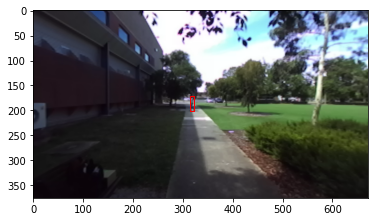

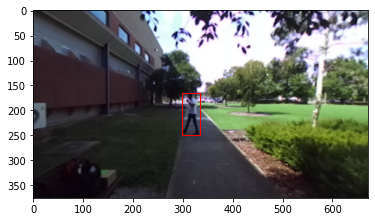

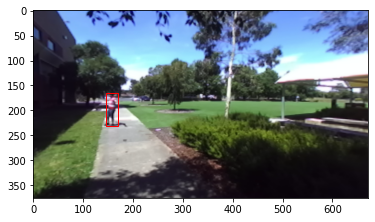

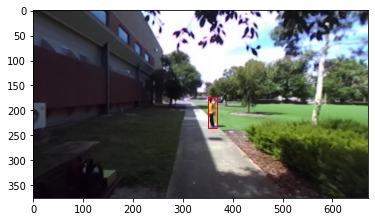

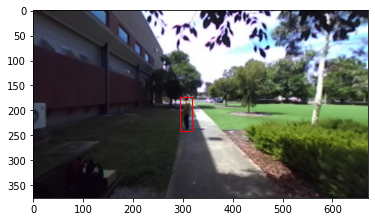

In [ ]:
samples = 5

for index, row in data.iterrows():
  if index >= samples:
    continue

  img = np.asarray(Image.open('./' + row["file_path"]))
  xmax = row["xmax"]
  ymax = row["ymax"]
  xmin = row["xmin"]
  ymin = row["ymin"]

  # Create a Rectangle patch
  rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='r', facecolor='none')

  # Create figure and axes
  fig, ax = plt.subplots()

  # Add the patch to the Axes
  ax.add_patch(rect)

  # Display the image
  ax.imshow(img)

## Image Resolutions

In [ ]:
largest_height = 0
largest_width = 0
most_bands = 0

img_list = list(data["file_path"])
unique_resolutions = set()

# Check image sizes
for image in img_list:
  img = Image.open('./' + image)
  img_numpy = np.ascontiguousarray(img, dtype=np.float32)
  if largest_height < img_numpy.shape[1]:
    largest_height = img_numpy.shape[1]
  if largest_width < img_numpy.shape[0]:
    largest_width = img_numpy.shape[0]
  if most_bands < img_numpy.shape[2]:
      most_bands = img_numpy.shape[2]
  key = f"({img_numpy.shape[0]}, {img_numpy.shape[1]}, {img_numpy.shape[2]})"
  if key not in unique_resolutions:
    unique_resolutions.add(key)

print("Unique Resolutions: " + str(unique_resolutions))
print("largest dimensions for all images: \nW:{} H:{} C:{}".format(largest_width, largest_height, most_bands))

Unique Resolutions: {'(376, 672, 4)'}
largest dimensions for all images: 
H:376 W:672 C:4


## Data Visualisation

### Functions

In [6]:
def hist_plot(title, columns, colours, nrows, ncols, index_pos, unique_count, xlabel=None, ylabel=None, left=0.125, top=0.9, bottom=0.1, right=0.9, wspace=0.3,
              hspace=0.7, rwidth=1, font_size=16):
    """
    Plots a histogram.
    :param title:       The title of the histogram.
    :param columns:     The data columns to plot on the histogram.
    :param colours:     The colours for each data column on the histogram.
    :param nrows:       The number of rows in the presentation table.
    :param ncols:       The number of columns in the presentation table.
    :param index_pos:   The index of the histogram on the
    :param unique_count The amount of unique results there are for the column.
    :param xlabel       The label for the x axis.
    :param ylabel       The label for the y axis.
    :param left:        How far to move away from left.
    :param top:         How far to move away from top.
    :param bottom:      How far to extend towards bottom.
    :param right:       How far to extend boundary towards right.
    :param wspace:      Height ratio spacing between plots.
    :param hspace:      Width ratio spacing between plots.
    :param rwidth:      The ratio of bar to bucket width. 1 = full cover.
    :param font_size    The size of the font on the axis names.
    :return:
    """
    # Make sub plots space according to parameters.
    plt.subplot(nrows, ncols, index_pos)

    # Give perfect amount of room around each plot to not overlap text.
    plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

    # Plot histogram for each column feature and assign corresponding colour.
    for index_pos, column in enumerate(columns):
      column.values.sort()
      plt.hist(column.values, alpha=0.3, color=colours[index_pos % len(colours)], density=True, rwidth=rwidth, bins=range(0, unique_count + 1), align='left')
    
    if xlabel is not None:
      plt.xlabel(xlabel, fontsize=font_size, fontstyle='italic') 

    if ylabel is not None:
      plt.ylabel(ylabel, fontsize=font_size, fontstyle='italic') 

    plt.title(title, fontsize=font_size)
    plt.xticks(rotation='vertical')

In [7]:
def bar_plot(title, column_dicts, colours, nrows, ncols, index_pos, unique_count, xlabel=None, ylabel=None, left=0.125, top=0.9, bottom=0.1, right=0.9, wspace=0.3,
              hspace=0.7, font_size=16):
    """
    Plots a bar graph.
    :param title:        The title of the histogram.
    :param column_dicts: The columns dicts to plot on the bars.
    :param colours:      The colours for each data column on the bars.
    :param nrows:        The number of rows in the presentation table.
    :param ncols:        The number of columns in the presentation table.
    :param index_pos:    The index of the histogram on the
    :param unique_count  The amount of unique results there are for the column.
    :param xlabel        The label for the x axis.
    :param ylabel        The label for the y axis.
    :param left:         How far to move away from left.
    :param top:          How far to move away from top.
    :param bottom:       How far to extend towards bottom.
    :param right:        How far to extend boundary towards right.
    :param wspace:       Height ratio spacing between plots.
    :param hspace:       Width ratio spacing between plots.
    :param font_size    The size of the font on the axis names.
    :return:
    """
    # Make sub plots space according to parameters.
    plt.subplot(nrows, ncols, index_pos)

    # Give perfect amount of room around each plot to not overlap text.
    plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

    # Plot histogram for each column feature and assign corresponding colour.
    for index_pos, dictionary in enumerate(column_dicts):
        plt.bar(dictionary.keys(), dictionary.values(),  alpha=0.3, color=colours[index_pos % len(colours)], align='center')
    
    if xlabel is not None:
      plt.xlabel(xlabel, fontsize=font_size, fontstyle='italic') 

    if ylabel is not None:
      plt.ylabel(ylabel, fontsize=font_size, fontstyle='italic') 

    plt.title(title, fontsize=font_size)
    plt.xticks(rotation='vertical')

In [8]:
def create_graphs(col, col_title, bins, xlabel, index_col, train_set, validation_set, test_set):
  # Graph Action Types
  plt.figure(figsize=(20, 30))
  rwidth=0.80

  # Frequencies
  ylabel = "Frequency Ratio : 1"

  title = "Train Set " + col_title + " Frequencies"
  hist_plot(title, [train_set[col]], [train_colour], 4, 2, 1, bins, rwidth=rwidth, xlabel=xlabel, ylabel=ylabel)

  title = "Validation Set " + col_title + " Frequencies"
  hist_plot(title, [validation_set[col]], [val_colour], 4, 2, 2, bins, rwidth=rwidth, xlabel=xlabel, ylabel=ylabel)

  title = "Test Set " + col_title + " Frequencies"
  hist_plot(title, [test_set[col]], [test_colour], 4, 2, 3, bins, rwidth=rwidth, xlabel=xlabel, ylabel=ylabel)

  title = "All 3 Dataset " + col_title + " Frequencies"
  hist_plot(title, [train_set[col], validation_set[col], test_set[col]], [train_colour, val_colour, test_colour], 4, 2, 4, bins, rwidth=rwidth, xlabel=xlabel, ylabel=ylabel)

  # Counts
  ylabel="Counts $n$"

  train_dict = dict(train_set.groupby(col)[index_col].nunique())
  val_dict = dict(validation_set.groupby(col)[index_col].nunique())
  test_dict = dict(test_set.groupby(col)[index_col].nunique())

  title = "Train Set " + col_title + " Counts"
  bar_plot(title, [train_dict], [train_colour], 4, 2, 5, bins, xlabel=xlabel, ylabel=ylabel)

  title = "Validation Set " + col_title + " Counts"
  bar_plot(title, [val_dict], [val_colour], 4, 2, 6, bins, xlabel=xlabel, ylabel=ylabel)

  title = "Test Set " + col_title + " Counts"
  bar_plot(title, [test_dict], [test_colour], 4, 2, 7, bins, xlabel=xlabel, ylabel=ylabel)

  title = "All 3 Dataset " + col_title + " Counts"
  bar_plot(title, [train_dict, val_dict, test_dict], [train_colour, val_colour, test_colour], 4, 2, 8, bins, xlabel=xlabel, ylabel=ylabel)

### Data

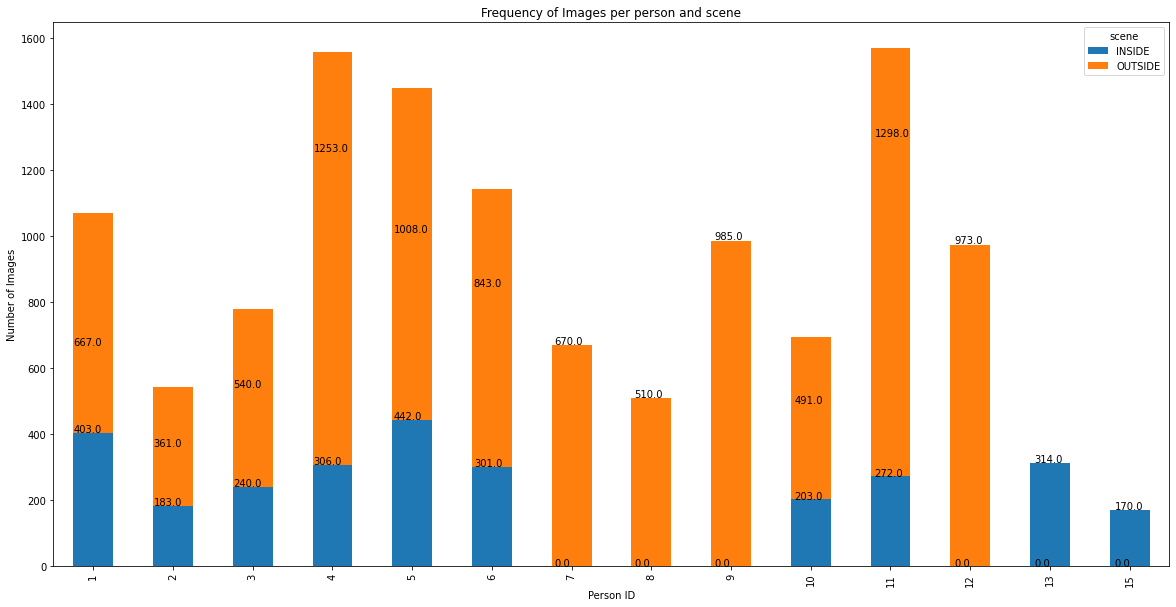

In [ ]:
ax = pd.crosstab(data['personID'], data['scene'], margins=False).plot.bar(stacked=True, 
                                                                    figsize=[20,10],
                                                                    title='Frequency of Images per person and scene',
                                                                    xlabel='Person ID',
                                                                    ylabel='Number of Images')

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

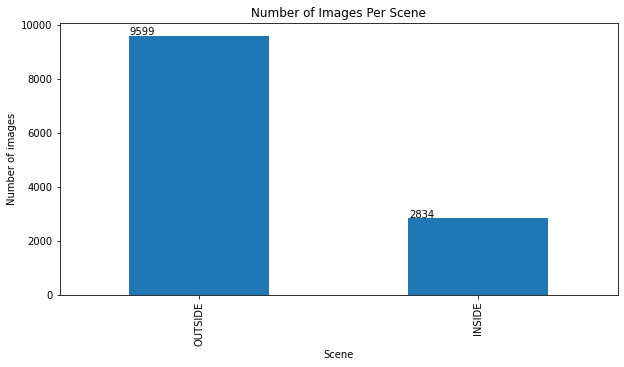

In [ ]:
ax = data.scene.value_counts().to_frame().plot(kind='bar',
                                          title='Number of Images Per Scene',
                                          xlabel='Scene', ylabel='Number of images',
                                          legend=False,
                                          figsize=[10,5])

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

## Split Data

The way the optimisation works is it performs 1 split per seed, given in the range, and adds the differences per category between, train, validation and test sets and their expected counts, whilst adhering to the split ratios. So if there is a lot of horse data in the train set compared to what was expected based off the train set being 60% the size of the whole set, that will create a large difference number etc. If the difference is much greater than 0 it is bad, where as closer distributed sets are closer to 0, with 0 being a perfect split of all categories among all 3 datasets, evenly.

### Functions

In [9]:
def train_val_test_split_by_column(dataframe, column, seed, train_fraction=0.666, val_fraction=0.5):
    """
    Creates the train, validation and test sets based on a column.
    :param dataframe:      The dataframe that holds the data.
    :param column:         The column to do the splitting on.
    :param seed:           The seed for the randomizer splitter.
    :param train_fraction: The size of the training set.
    :param val_fraction:   The size of the validation set, with the left overs being the test set.
    :return: The train, validation and test sets.
    """

    # Getting the unique column values to split on so that same values are not in different sets.
    splitting_IDs = dataframe[column].unique()

    # Split the train set from the rest.
    train_IDs, test_IDs = train_test_split(splitting_IDs, train_size=train_fraction, shuffle=True, random_state=seed)

    # Split the left over into the validation and test sets.
    val_IDs, test_IDs = train_test_split(test_IDs, train_size=val_fraction, shuffle=True, random_state=seed)

    # Turn into dataframe.
    train_IDs = pd.DataFrame(train_IDs)

    # Create column split with values being train. This lets us distinguish the
    # training data from the other data sets when we merge them all together.
    train_IDs.rename(columns={0: column}, inplace=True)
    train_IDs['split'] = 'train'

    # Turn into dataframe.
    val_IDs = pd.DataFrame(val_IDs)

    # Create column split with values being validation. This lets us distinguish the
    # validation data from the other data sets when we merge them all together.
    val_IDs.rename(columns={0: column}, inplace=True)
    val_IDs['split'] = 'validation'

    # Turn into dataframe.
    test_IDs = pd.DataFrame(test_IDs)

    # Create column split with values being test. This lets us distinguish the
    # test data from the other data sets when we merge them all together.
    test_IDs.rename(columns={0: column}, inplace=True)
    test_IDs['split'] = 'test'

    # Combine the split ids
    splits = pd.concat([train_IDs, val_IDs, test_IDs], ignore_index=True)

    # Add the new columns to original dataframe.
    dataframe = pd.merge(dataframe, splits, on=column)

    # Extract the training set where split equals train.
    train_set = dataframe[dataframe['split'] == 'train']
    train_set = train_set.drop(['split'], axis=1)

    # Extract the validation set where split equals validation.
    validation_set = dataframe[dataframe['split'] == 'validation']
    validation_set = validation_set.drop(['split'], axis=1)

    # Extract the test set where split equals test.
    test_set = dataframe[dataframe['split'] == 'test']
    test_set = test_set.drop(['split'], axis=1)

    return train_set, validation_set, test_set

In [10]:
def get_variance_between_datasets(data, index_col, train_set, validation_set, test_set, cols, train_fraction, validation_fraction):
  """
  Gets the maximum value for each category in the column and calculates how far the other 
  datasets differ from this maximum value in percentage. The differences are 
  added together to create an accumulated difference %. and then each 
  accumulated difference per cell type is added together to create the total 
  accumulated variance.
  
  :param data:           The dataframe containing the data.
  :pram index_col:       The column that the data is unique on.
  :param train_set:      The training data set.
  :param validation_set: The validation data set.
  :param test_set:       The testing data set.
  :param cols:           The columns to calculate and sum the variance on.
  :return: The accumulated difference over the column.
  """

  # Deduce actual test size and validation size.
  remainder_of_the_pie = 1 - train_fraction
  actual_val_fraction = remainder_of_the_pie * validation_fraction
  actual_test_fraction = remainder_of_the_pie - actual_val_fraction

  # Initialise varaince to 0.
  total_variance = 0

  # For each target column, get the variance of the data between the datasets.
  for y_col in cols:

    train_values = dict(train_set.groupby(y_col)[index_col].nunique())
    validation_values = dict(validation_set.groupby(y_col)[index_col].nunique())
    test_values = dict(test_set.groupby(y_col)[index_col].nunique())


    # Loop through the different categories in main data.
    for key in data.groupby(cols)[index_col].nunique().keys().values:

      # Get the frequency count for each cell type, 0 if class doesn't exist.
      actual_train_count = train_values[key] if key in train_values else 0
      actual_val_count = validation_values[key] if key in validation_values else 0
      actual_test_count = test_values[key] if key in test_values else 0

      # Get total count of data.
      total_count = actual_train_count + actual_val_count + actual_test_count

      # Get the expected count for each dataset.
      train_expected_count = total_count * train_fraction
      val_expected_count = total_count * actual_val_fraction
      test_expected_count = total_count * actual_test_fraction

      # Get the difference between the expected count and the actual count.
      train_diff = abs(train_expected_count - actual_train_count)
      val_diff = abs(val_expected_count - actual_val_count)
      test_diff = abs(test_expected_count - actual_test_count)

      # Get the total difference in how much the data sets differ from the expected values.
      # Best case scenario is that they are all equal and difference = 0.
      total_variance += train_diff + val_diff + test_diff
  
  return total_variance


In [11]:
def optimise_split(data_set, index_col, target_columns, iterations, train_fraction=0.666, val_fraction=0.5):
  """
    Optimises the split by splitting many times to find the split that contains the least variance in data across all splits on an optimised column.
    :param data_set:       The data set to split.
    :param index_col:      The column to split on, the unique values column or index.
    :param target_columns: The target columns to calculate the variance on.
    :param iterations:     How many seeds to check from 0.
    :return: The optimal seed and the variance for the seed.
    """
  seed = 0
  smallest_variance = 9999
  
  for i in range(1, iterations):
  
    # Split the data based on patient ID.
    train_set, val_set, test_set = train_val_test_split_by_column(data_set, index_col, i, train_fraction, val_fraction)

    # Calculate the variance between the three datasets.
    variance = get_variance_between_datasets(data_set, index_col, train_set, val_set, test_set, target_columns, train_fraction, val_fraction)

    if variance < smallest_variance:
      smallest_variance = variance
      seed = i

  return seed, smallest_variance

### Split

In [15]:
# Split the data
train_fraction = 0.8
val_fraction = 0.5

# The column that is used as the index/primary key for the dataframe.
index_col = "file_path"

In [ ]:
seed, smallest_variance = optimise_split(data, index_col, ['scene', 'personID'], 200, train_fraction, val_fraction)

print("Best seed: " + str(seed))
print("Accumulated Variance: " + str(smallest_variance))

Best seed: 1
Accumulated Variance: 0.0


In [16]:
# Split on the ultimate seed split with the least variance over the patient data.
seed = 1
train_set, validation_set, test_set = train_val_test_split_by_column(data, index_col, seed, train_fraction, val_fraction)

In [ ]:
train_set.head()

,file_path,distance,scene,personID,xmax,xmin,ymax,ymin
0,Images/07_OUTSIDE_1198.png,14.9,OUTSIDE,7,323.16498,313.81473,201.65112,170.32014
1,Images/01_OUTSIDE_3420.png,6.7,OUTSIDE,1,333.87970,297.28207,249.00247,165.39919
2,Images/11_OUTSIDE_5506.png,7.3,OUTSIDE,11,169.90585,145.17395,231.83516,165.30717
3,Images/06_OUTSIDE_3869.png,7.9,OUTSIDE,6,369.01447,349.55515,234.96034,174.08122
5,Images/09_OUTSIDE_1805.png,14.7,OUTSIDE,9,224.99360,215.01001,201.14867,169.35344


### Visualise Splits

In [14]:
# Define the colours for the graphs.
train_colour = "blue"
val_colour = "red"
test_colour = "green"

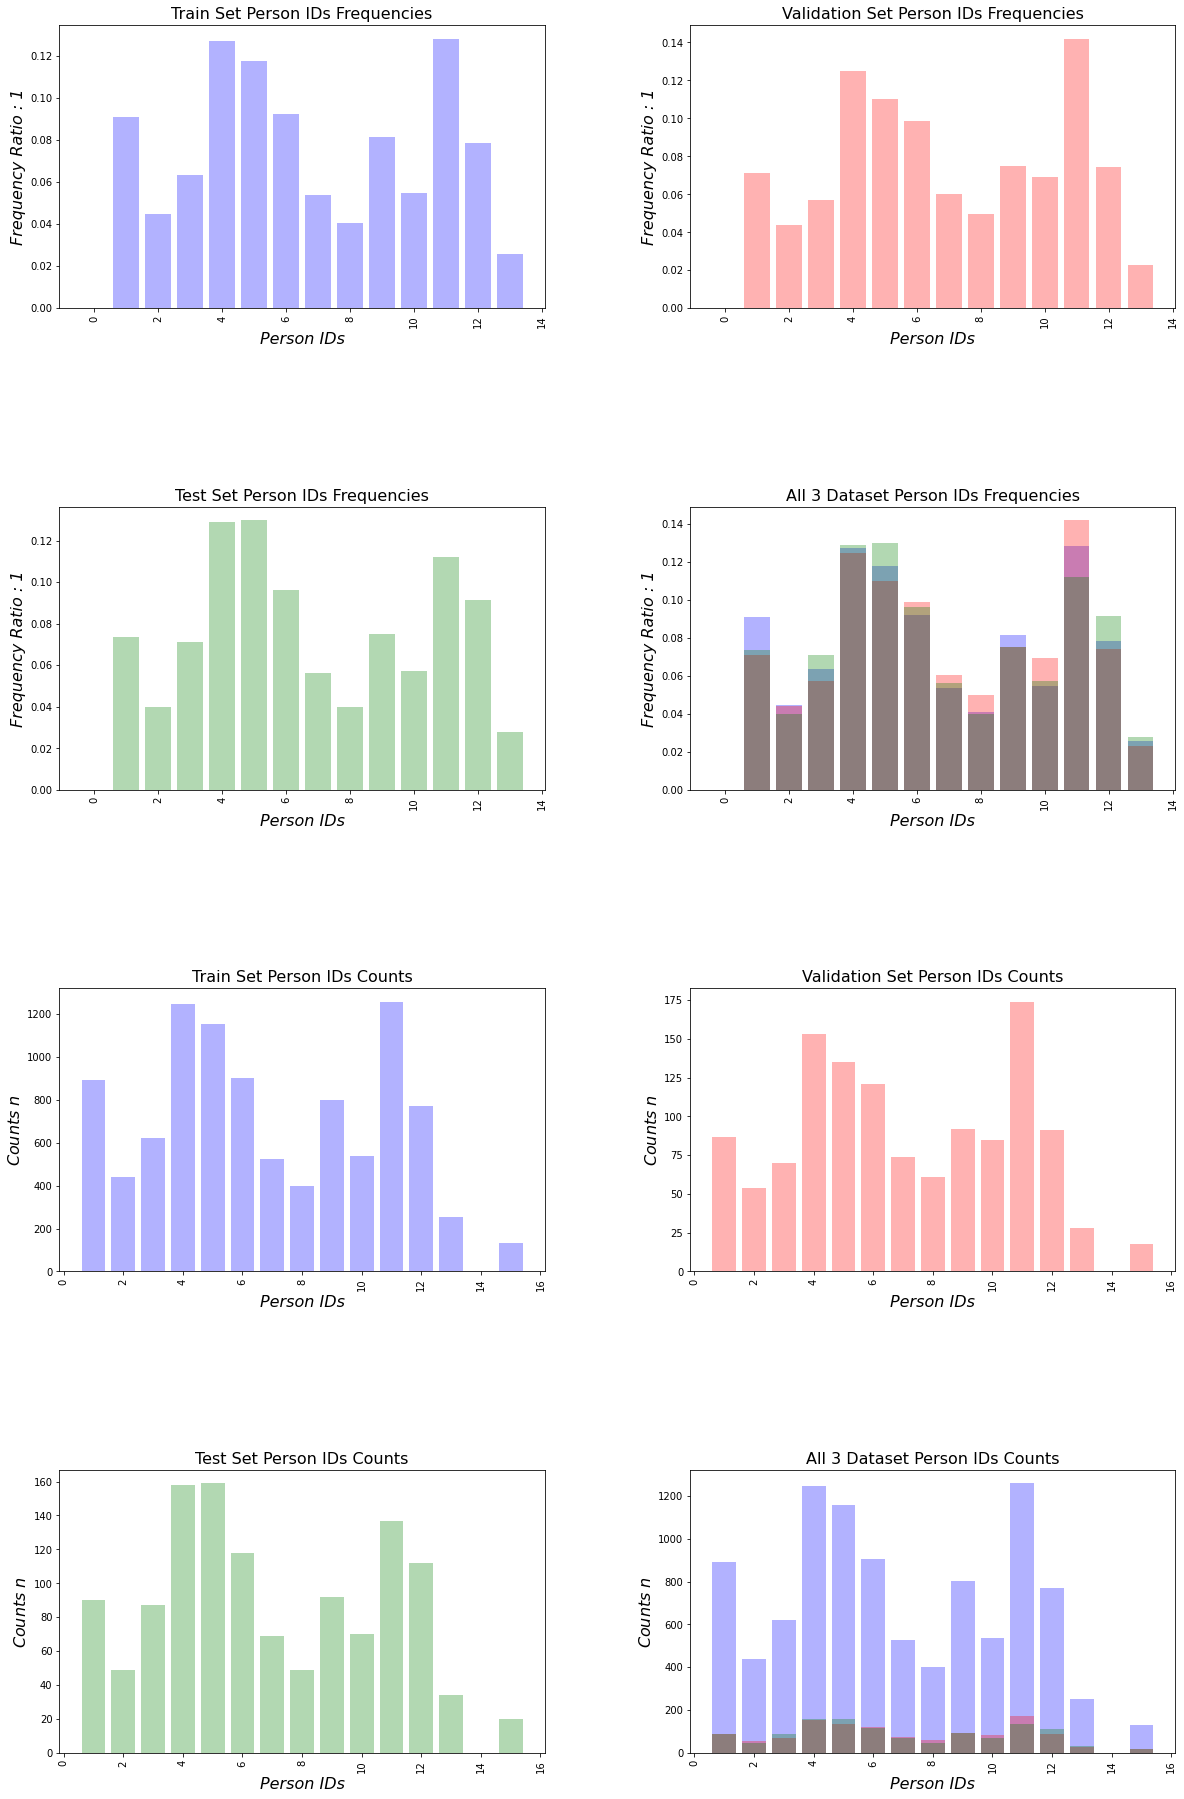

In [ ]:
bins = data["personID"].nunique()
create_graphs("personID", "Person IDs", bins, "Person IDs", index_col, train_set, validation_set, test_set)

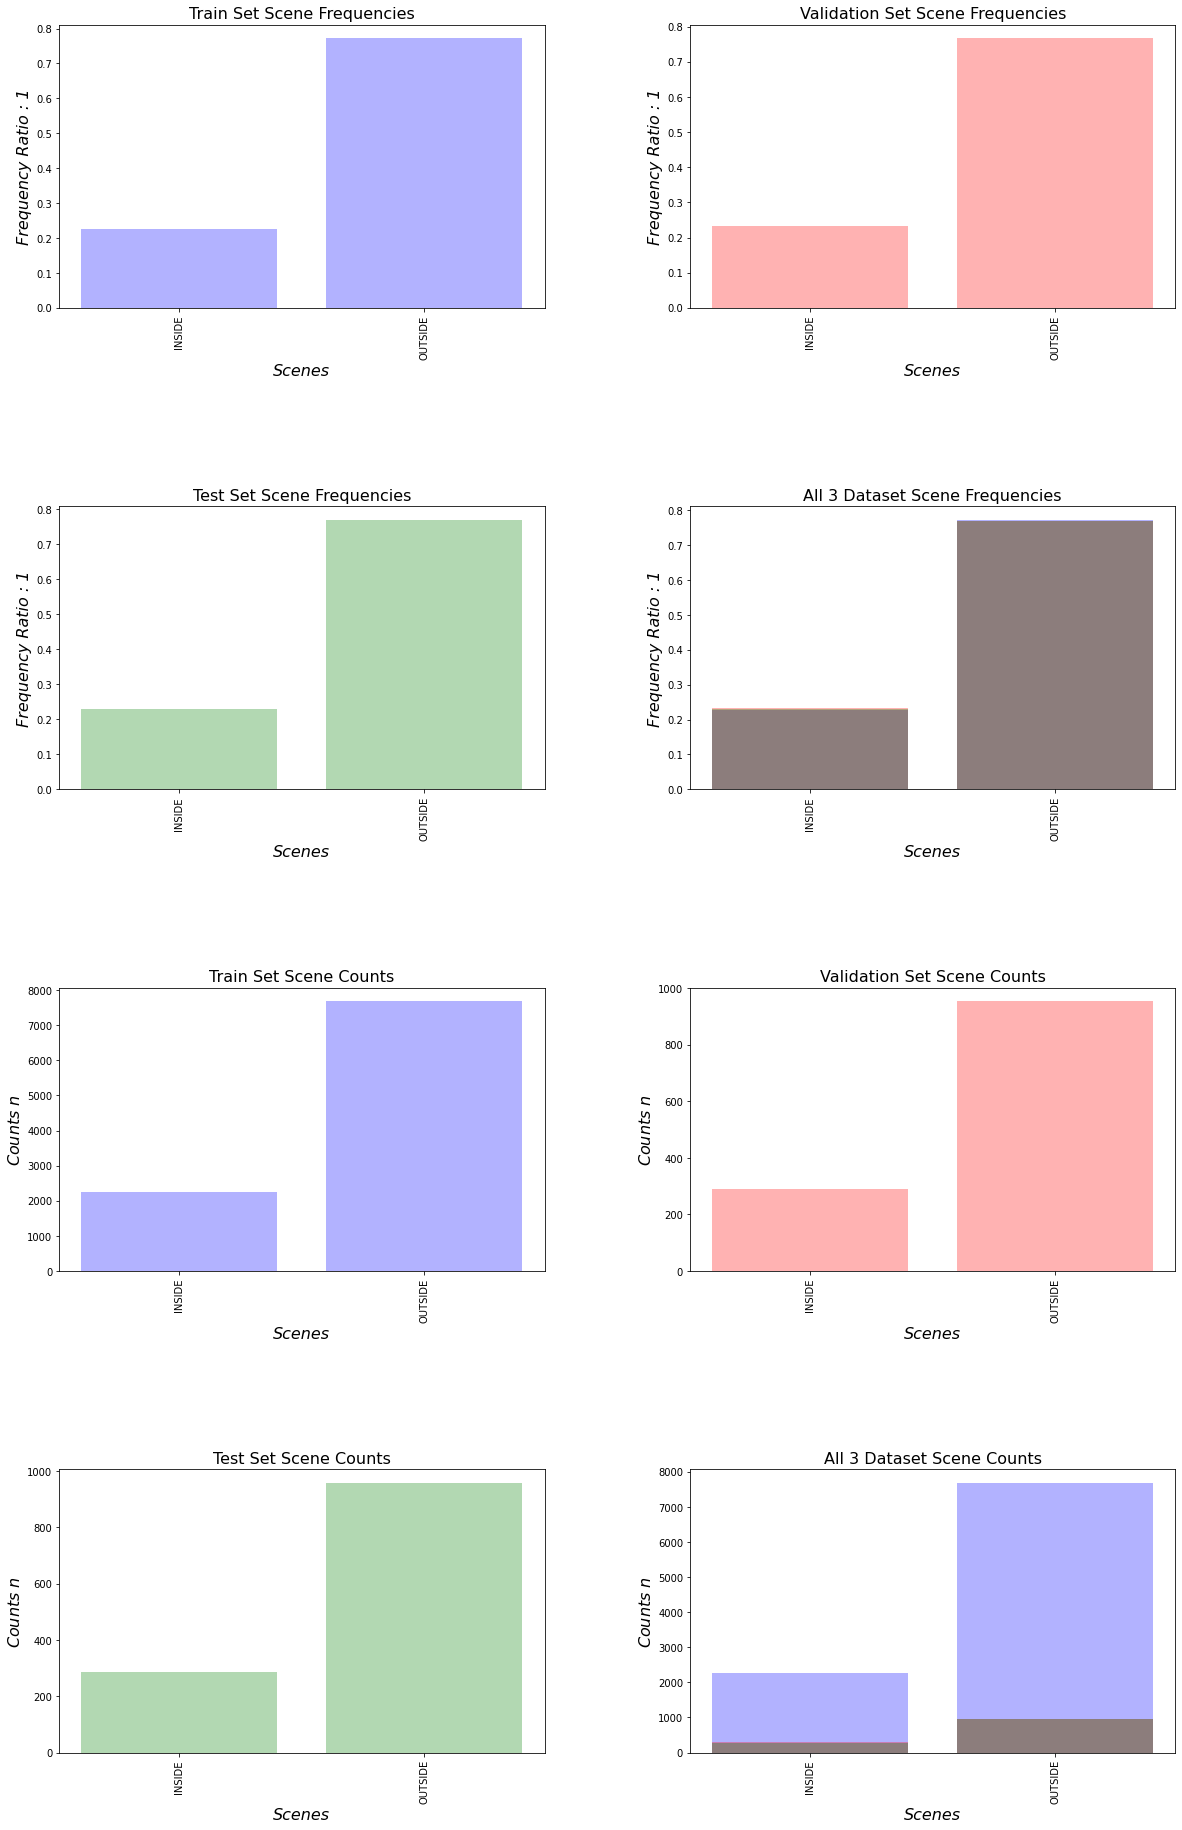

In [ ]:
bins = data["scene"].nunique()
create_graphs("scene", "Scene", bins, "Scenes", index_col, train_set, validation_set, test_set)

## Performance Metric
Mean Average Precision
mAP@0.5 and mAP@0.25


👨🏻‍🎓 **Conclusions**
> - 



[Ref](https://www.datacamp.com/community/tutorials/object-detection-guide)



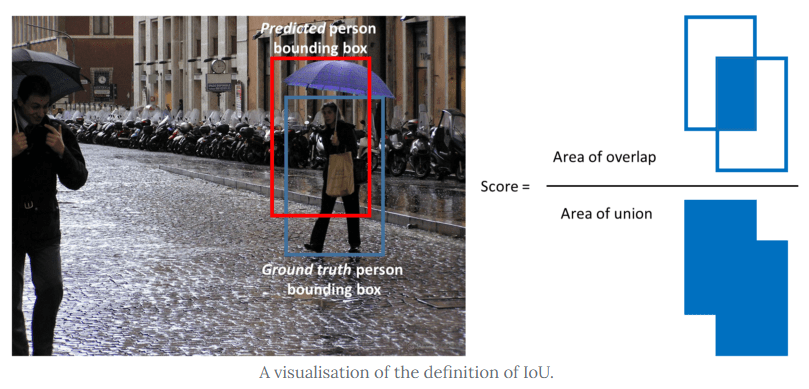

## Base Model

There was needed a base model to help initialise the weights of the model to be in a state that is already familiart and suited to this calssification task. Two base models were chosen based on the complexity of the models and pramater output size. 


Both these base models will be frozen and not fine tuned do to the size of them after the head has been tuned. If there was more resources dedicated towards also finetuning the base model for the task, that would be good for further future investigation.

👨🏻‍🎓 **Conclusions**
> - Test both base models:
    - YOLOv3

## Optimizer

Adam will be the opimizers to test going forward.
Adam will be used purely for it's speed increase to a models training.
Though SGD is good as an optimizer as well, it is very slow compared to Adam and requires a learning rate that is not small. The learnig rate that will be chosen for this project will be quite smaller, being around 0.0005.


[1]: Wilson, Ashia C. et al. “The Marginal Value of Adaptive Gradient Methods in Machine Learning.” ArXiv abs/1705.08292 (2017): n. pag

# Literature Review
https://hal.archives-ouvertes.fr/hal-02343350/document

Depth Perception

https://arxiv.org/pdf/1909.05483v1.pdf

https://arxiv.org/abs/1806.01260

https://arxiv.org/pdf/1609.03677.pdf

https://arxiv.org/pdf/2011.14141v1.pdf




- SSD architecture
- R-CNN
- Fast-R-CNN
- Faster-R-CNN
- YOLOv3



## Depth Estimation

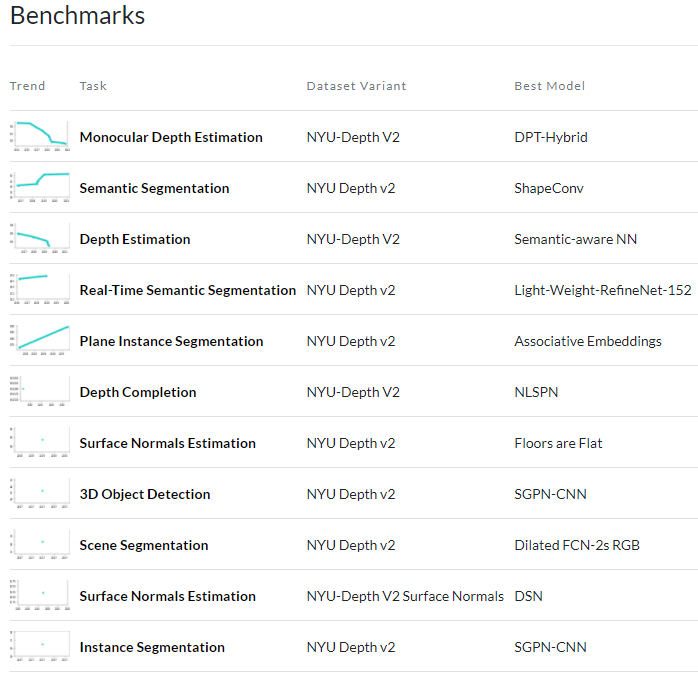

## AdaBins
Depth Estimation using Adaptive Bins

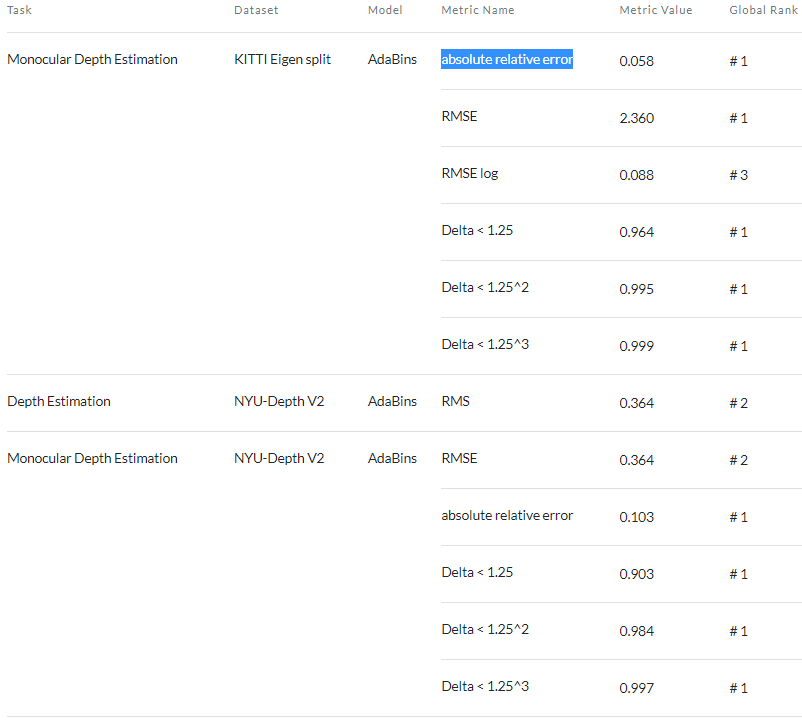

## Object Detection

### SSD Architecture
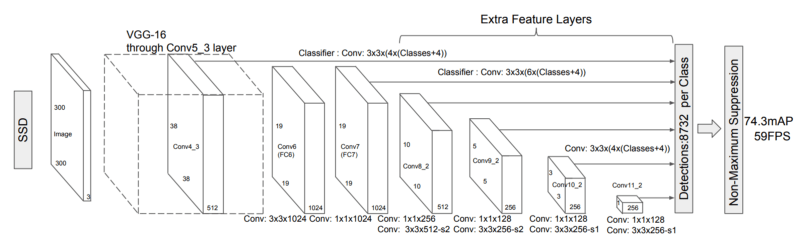

### YOLO v3 Architecture
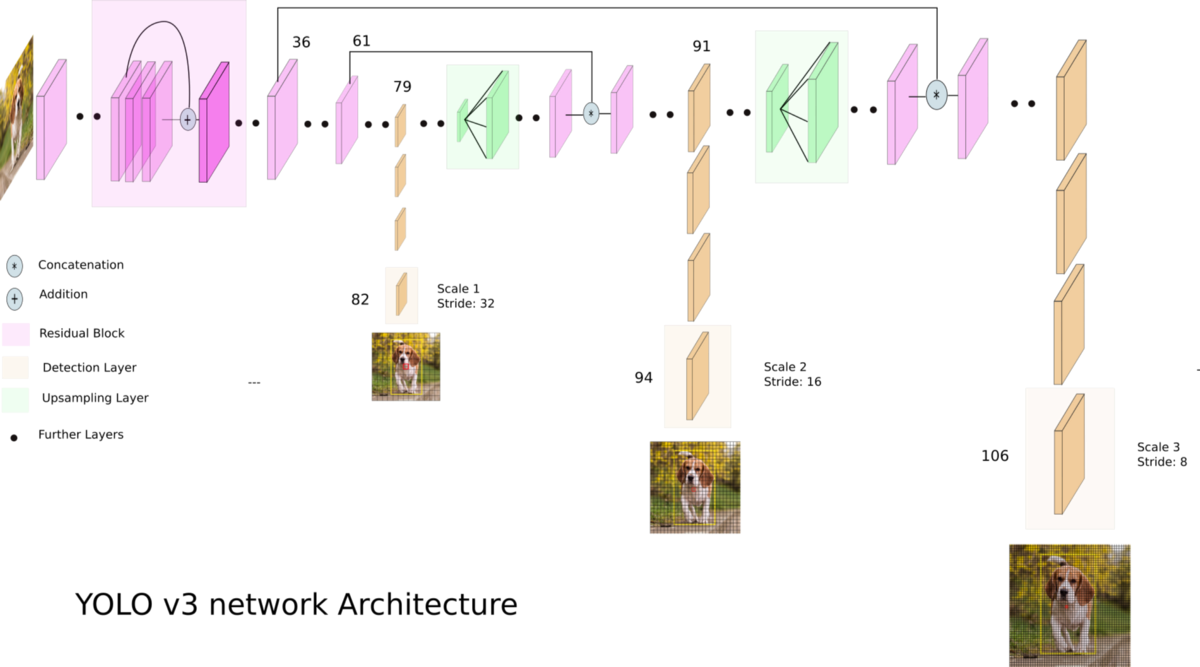

## Estimate Anchor Boxes From Training Data

# Setup


## Model Saving Functions

In [17]:
def setup_model_store(model_name):
    """
    Sets up the paths and directories necessary to save the model and training history of that model.
    :param model_name: The name of the model.
    :return: The full path of the model directory and the full path location for the history.
    """
    # Train MLP.
    print("~~~~~~~~~~ " + model_name + " ~~~~~~~~~~")

    # Root google dir.
    root_dir = "/content/drive/My Drive/Deep_Learning/"

    # Get root dir for this model.
    model_dir = root_dir + "models/" + model_name

    # Make path for models.
    model_path = model_dir + "/checkpoint.tf"

    # Make path for history logs.
    history_path = model_dir + "/history.csv"

    # Make a directory if it doesn't exist. Any error output do not show.
    !mkdir / content / drive / 'My Drive' / CML-Assignment-2 / {model_dir} 2 > / dev / null

    return model_path, history_path

Create Custom Callback to save epock checkpoint history to history file

In [18]:
# Create call back to provide an update message of the model after epoch end.
class UpdateHistoryCallback(keras.callbacks.Callback):
    def __init__(self, history_path, epochs_completed, total_epochs):
      self.history_path = history_path
      self.epochs_completed = epochs_completed
      self.total_epochs = total_epochs

    def on_epoch_end(self, epoch, logs=None):

      # Check the history csv exists.
      exists = os.path.isfile(self.history_path)
      with open(self.history_path, 'a') as file:
        
        # Append header line to csv if file is newly created.
        if not exists:
          file.write(",".join(logs.keys()) + "\n")
        
        # Write the epoch's metrics to history file.
        file.write(",".join(map(str, logs.values())) + "\n")
        print("Epoch " + str(self.epochs_completed + epoch + 1) + "/" + str(self.total_epochs) + " Complete")

Create the auto save and auto load function.
Can auto continue training from last saved epoch.

In [19]:
def run_model(model, parameters, model_name, train_generator, val_generator, extend_model_name=None):
    """
    Runs a model but checks if it is already saved and loads it in if it exists.
    Otherwise it fits the model and saves the model and it's history.
    :param model:            The model to fit.
    :param parameters:       The hyper parameters.
    :param model_name:       The name of the model.
    :param train_generator:  The train generator.
    :param val_generator:    The validation generator.
    :param extend_model_name The name of the model to extend from with further training.
    :return: The history created/found and the model created/found.
    """
    
    previous_model_name = model_name
    

    # Setup the directories and paths for saving and loading the model and history.
    model_path, history_path, = setup_model_store(model_name)
    
    continue_training = False
    epochs = parameters["epochs"]
    trained_epochs = 0
    try:
      # Load a model that exists.
      model = tf.keras.models.load_model(model_path)
      print("Accessed: " + model_path)

      # Read in the history chart from fitting the model previously.
      history = pd.read_csv(history_path, delimiter=',')
      print("Accessed: " + history_path)

      # Check if the model was stopped early in training
      trained_epochs = len(history['loss'])

      # Check if the model can prematurely stopped training.
      if trained_epochs < epochs:
        
        # Continue where the model left off from.
        continue_training = True

        # Set the remaining amount of epochs to train on the model.
        epochs = epochs - trained_epochs
        raise  Exception()
    except:

      # If create new model
      if not continue_training:

        # If create new model from existing model
        if extend_model_name is not None:
          mp, h = setup_model_store(extend_model_name)

          # Copy existing history from model to new one.
          dir = os.path.dirname(history_path)
          os.mkdir(dir)
          copy2(h, history_path)


          # Load other model to train from
          model = tf.keras.models.load_model(mp)
        else:

          # If create new model from scratch
          print("Creating new model..")
          # Compile the model with the hyper parameters chosen.
          model.compile(optimizer=parameters["optimizer"],
                        loss=parameters["loss"],
                        metrics=parameters["metrics"])
      else:

        print("Continuing training model ...")
        print("Epochs done: " + str(trained_epochs))  
        print("Epochs left: " + str(epochs))
      
      checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(model_path, monitor='loss', verbose=1, save_best_only=True, mode='min')
      history_cb = UpdateHistoryCallback(history_path, trained_epochs, parameters["epochs"])

      # Fit the model with the generators, and epoch amount.
      model.fit(train_generator,
                validation_data=val_generator, 
                epochs=epochs, 
                verbose=0,  
                callbacks = [checkpoint_cb, history_cb])
    
    history = pd.read_csv(history_path, delimiter=',')
    return history, model

## Data Generators Creator

In [20]:
def get_imagery_data_sets(train_set, validation_set, test_set, directory, x_col, y_col, batch_size, target_size, aug_params=None):
    """
    Gets the imagery data from the reference id's in each data set.
    :param train_set: The dataframe containing the set of ids in the training set.
    :param validation_set: The dataframe containing the set of validation ids.
    :param test_set: The dataframe containing the test ids.
    :param directory: The directory that the images are located.
    :param y_col: The target column name to make the taget column into a string type.
    :param batch_size: The batch size to which the data generator batches the imagery data.
    :param aug_params: the parameters for the data generator for the training set to help augment the data.
    :return: Returns the 3 data generators (train, validation, test) that have the images data.
    """

    # Transform the pixel values between 0 and 1, by dividing their values by 1/255
    train_datagen = ImageDataGenerator(rescale=1. / 255, data_format='channels_last') if aug_params == None else ImageDataGenerator(rescale=1. / 255, data_format='channels_last', **aug_params)
    val_datagen = ImageDataGenerator(rescale=1. / 255, data_format='channels_last')
    test_datagen = ImageDataGenerator(rescale=1. / 255, data_format='channels_last')

    # The parameters that all data set generators have in common.
    generator_parameters = dict(
        directory=directory,
        x_col=x_col,
        y_col=y_col,
        # TODO Get file_path
        target_size=target_size,
        color_mode="rgba",
        class_mode='multi_output',
        shuffle=False)

    # Train set generator to evaluate produce dataframe with train images.
    train_imagery_set = train_datagen.flow_from_dataframe(
        dataframe=train_set,
        batch_size=batch_size,
        **generator_parameters)

    # Validation set generator to evaluate produce dataframe with validation images.
    val_imagery_set = val_datagen.flow_from_dataframe(
        dataframe=validation_set,
        batch_size=batch_size,
        **generator_parameters)

    # Test set generator to evaluate produce dataframe with test images.
    test_imagery_set = test_datagen.flow_from_dataframe(
        dataframe=test_set,
        batch_size=1,
        **generator_parameters)

    return train_imagery_set, val_imagery_set, test_imagery_set

Found 9946 validated image filenames.
Found 1243 validated image filenames.
Found 1244 validated image filenames.


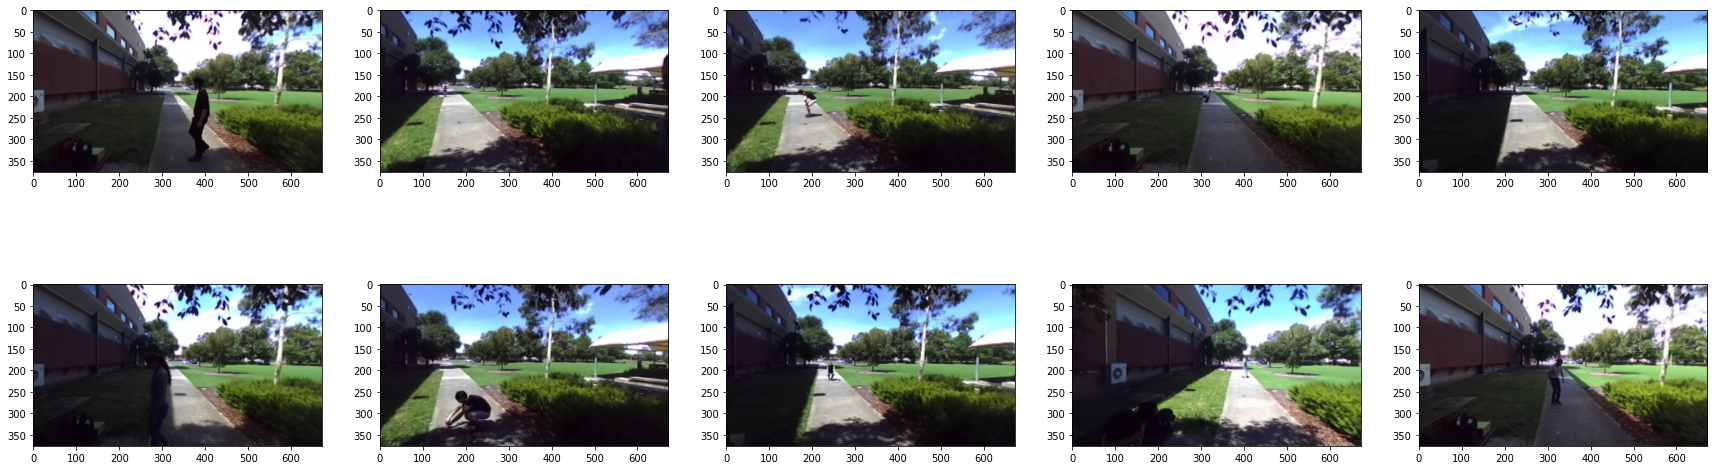

In [ ]:
train_gen, val_gen, test_gen = get_imagery_data_sets(train_set, val_set, test_set, "./", 'file_path', ["xmin", "ymin", "xmax", "ymax"], 5, (376, 672))

plt.figure(figsize=[30, 100])

count = 0
for i in range(0, 2):
  x,y = train_gen.__getitem__(i)
  img_in_batch = x.shape[0]
  for index in range(0, img_in_batch):
    img = x[index]
    plt.subplot(20, 5, count + 1)

    count += 1

    plt.imshow(img)


# YOLOv3 Person Detection

## Functions

In [24]:
class WeightReader:
    def __init__(self, weight_file):
        with open(weight_file, 'rb') as w_f:
            major,    = struct.unpack('i', w_f.read(4))
            minor,    = struct.unpack('i', w_f.read(4))
            revision, = struct.unpack('i', w_f.read(4))

            if (major*10 + minor) >= 2 and major < 1000 and minor < 1000:
                w_f.read(8)
            else:
                w_f.read(4)

            transpose = (major > 1000) or (minor > 1000)
            
            binary = w_f.read()

        self.offset = 0
        self.all_weights = np.frombuffer(binary, dtype='float32')
        
    def read_bytes(self, size):
        self.offset = self.offset + size
        return self.all_weights[self.offset-size:self.offset]

    def load_weights(self, model):
        for i in range(106):
            try:
                conv_layer = model.get_layer('conv_' + str(i))
                print("loading weights of convolution #" + str(i))

                if i not in [81, 93, 105]:
                    norm_layer = model.get_layer('bnorm_' + str(i))

                    size = np.prod(norm_layer.get_weights()[0].shape)

                    beta  = self.read_bytes(size) # bias
                    gamma = self.read_bytes(size) # scale
                    mean  = self.read_bytes(size) # mean
                    var   = self.read_bytes(size) # variance            

                    weights = norm_layer.set_weights([gamma, beta, mean, var])  

                if len(conv_layer.get_weights()) > 1:
                    bias   = self.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel, bias])
                else:
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel])
            except ValueError:
                print("no convolution #" + str(i))     
    
    def reset(self):
        self.offset = 0

def _conv_block(inp, convs, skip=True):
    x = inp
    count = 0
    
    for conv in convs:
        if count == (len(convs) - 2) and skip:
            skip_connection = x
        count += 1
        
        if conv['stride'] > 1: x = ZeroPadding2D(((1,0),(1,0)))(x) # peculiar padding as darknet prefer left and top
        x = Conv2D(conv['filter'], 
                   conv['kernel'], 
                   strides=conv['stride'], 
                   padding='valid' if conv['stride'] > 1 else 'same', # peculiar padding as darknet prefer left and top
                   name='conv_' + str(conv['layer_idx']), 
                   use_bias=False if conv['bnorm'] else True)(x)
        if conv['bnorm']: x = BatchNormalization(epsilon=0.001, name='bnorm_' + str(conv['layer_idx']))(x)
        if conv['leaky']: x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)

    return add([skip_connection, x]) if skip else x

In [59]:
# load yolov3 model and perform object detection
# based on https://github.com/experiencor/keras-yolo3
import numpy as np
from numpy import expand_dims
from keras.models import load_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from matplotlib import pyplot
from matplotlib.patches import Rectangle

class BoundBox:
	def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
		self.xmin = xmin
		self.ymin = ymin
		self.xmax = xmax
		self.ymax = ymax
		self.objness = objness
		self.classes = classes
		self.label = -1
		self.score = -1

	def get_label(self):
		if self.label == -1:
			self.label = np.argmax(self.classes)

		return self.label

	def get_score(self):
		if self.score == -1:
			self.score = self.classes[self.get_label()]

		return self.score

def _sigmoid(x):
	return 1. / (1. + np.exp(-x))

def decode_netout(netout, anchors, obj_thresh, net_h, net_w):
	grid_h, grid_w = netout.shape[:2]
	nb_box = 3
	netout = netout.reshape((grid_h, grid_w, nb_box, -1))
	nb_class = netout.shape[-1] - 5
	boxes = []
	netout[..., :2]  = _sigmoid(netout[..., :2])
	netout[..., 4:]  = _sigmoid(netout[..., 4:])
	netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
	netout[..., 5:] *= netout[..., 5:] > obj_thresh

	for i in range(grid_h*grid_w):
		row = i / grid_w
		col = i % grid_w
		for b in range(nb_box):
			# 4th element is objectness score
			objectness = netout[int(row)][int(col)][b][4]
			if(objectness.all() <= obj_thresh): continue
			# first 4 elements are x, y, w, and h
			x, y, w, h = netout[int(row)][int(col)][b][:4]
			x = (col + x) / grid_w # center position, unit: image width
			y = (row + y) / grid_h # center position, unit: image height
			w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
			h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height
			# last elements are class probabilities
			classes = netout[int(row)][col][b][5:]
			box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
			boxes.append(box)
	return boxes

def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
	new_w, new_h = net_w, net_h
	for i in range(len(boxes)):
		x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
		y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
		boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
		boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
		boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
		boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

def _interval_overlap(interval_a, interval_b):
	x1, x2 = interval_a
	x3, x4 = interval_b
	if x3 < x1:
		if x4 < x1:
			return 0
		else:
			return min(x2,x4) - x1
	else:
		if x2 < x3:
			 return 0
		else:
			return min(x2,x4) - x3

def bbox_iou(box1, box2):
	intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
	intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
	intersect = intersect_w * intersect_h
	w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
	w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
	union = w1*h1 + w2*h2 - intersect
	return float(intersect) / union

def do_nms(boxes, nms_thresh):
	if len(boxes) > 0:
		nb_class = len(boxes[0].classes)
	else:
		return
	for c in range(nb_class):
		sorted_indices = np.argsort([-box.classes[c] for box in boxes])
		for i in range(len(sorted_indices)):
			index_i = sorted_indices[i]
			if boxes[index_i].classes[c] == 0: continue
			for j in range(i+1, len(sorted_indices)):
				index_j = sorted_indices[j]
				if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
					boxes[index_j].classes[c] = 0

# load and prepare an image
def load_image_pixels(filename, shape):
	# load the image to get its shape
	image = load_img(filename)
	width, height = image.size
	# load the image with the required size
	image = load_img(filename, target_size=shape)
	# convert to numpy array
	image = img_to_array(image)
	# scale pixel values to [0, 1]
	image = image.astype('float32')
	image /= 255.0
	# add a dimension so that we have one sample
	image = expand_dims(image, 0)
	return image, width, height

# get all of the results above a threshold
def get_boxes(boxes, labels, thresh):
	v_boxes, v_labels, v_scores = list(), list(), list()
	# enumerate all boxes
	for box in boxes:
		# enumerate all possible labels
		for i in range(len(labels)):
			# check if the threshold for this label is high enough
			if box.classes[i] > thresh:
				v_boxes.append(box)
				v_labels.append(labels[i])
				v_scores.append(box.classes[i]*100)
				# don't break, many labels may trigger for one box
	return v_boxes, v_labels, v_scores

# draw all results
def draw_boxes(filename, v_boxes, v_labels, v_scores):
	# load the image
	data = pyplot.imread(filename)
	# plot the image
	pyplot.imshow(data)
	# get the context for drawing boxes
	ax = pyplot.gca()
	# plot each box
	for i in range(len(v_boxes)):
		box = v_boxes[i]
		# get coordinates
		y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
		# calculate width and height of the box
		width, height = x2 - x1, y2 - y1
		# create the shape
		rect = Rectangle((x1, y1), width, height, fill=False, color='white')
		# draw the box
		ax.add_patch(rect)
		# draw text and score in top left corner
		label = "%s (%.3f)" % (v_labels[i], v_scores[i])
		pyplot.text(x1, y1, label, color='white')
	# show the plot
	pyplot.show()

## Create YOLO V3 Model

In [26]:
def make_yolov3_model():
    input_image = Input(shape=(None, None, 3))

    # Layer  0 => 4
    x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
                                  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
                                  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
                                  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])

    # Layer  5 => 8
    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
                        {'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])

    # Layer  9 => 11
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])

    # Layer 12 => 15
    x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
                        {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
                        {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])

    # Layer 16 => 36
    for i in range(7):
        x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
                            {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
        
    skip_36 = x
        
    # Layer 37 => 40
    x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])

    # Layer 41 => 61
    for i in range(7):
        x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41+i*3},
                            {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42+i*3}])
        
    skip_61 = x
        
    # Layer 62 => 65
    x = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])

    # Layer 66 => 74
    for i in range(3):
        x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
                            {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])
        
    # Layer 75 => 79
    x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)

    # Layer 80 => 82
    yolo_82 = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 80},
                              {'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}], skip=False)

    # Layer 83 => 86
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_61])

    # Layer 87 => 91
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}], skip=False)

    # Layer 92 => 94
    yolo_94 = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 92},
                              {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}], skip=False)

    # Layer 95 => 98
    x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,   'layer_idx': 96}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_36])

    # Layer 99 => 106
    yolo_106 = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 99},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 100},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 101},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 102},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 103},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 104},
                               {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}], skip=False)

    model = Model(input_image, [yolo_82, yolo_94, yolo_106])    
    return model

In [27]:
# Make the yolov3 model to predict 80 classes on COCO.
yolov3 = make_yolov3_model()

In [28]:
weights_path = "/content/drive/MyDrive/DL/yolov3.weights"

# Load the weights trained on COCO into the model.
weight_reader = WeightReader(weights_path)
weight_reader.load_weights(yolov3)

loading weights of convolution #0
loading weights of convolution #1
loading weights of convolution #2
loading weights of convolution #3
no convolution #4
loading weights of convolution #5
loading weights of convolution #6
loading weights of convolution #7
no convolution #8
loading weights of convolution #9
loading weights of convolution #10
no convolution #11
loading weights of convolution #12
loading weights of convolution #13
loading weights of convolution #14
no convolution #15
loading weights of convolution #16
loading weights of convolution #17
no convolution #18
loading weights of convolution #19
loading weights of convolution #20
no convolution #21
loading weights of convolution #22
loading weights of convolution #23
no convolution #24
loading weights of convolution #25
loading weights of convolution #26
no convolution #27
loading weights of convolution #28
loading weights of convolution #29
no convolution #30
loading weights of convolution #31
loading weights of convolution #32

[YOLOv3 Architecture](https://miro.medium.com/max/1200/1*d4Eg17IVJ0L41e7CTWLLSg.png)

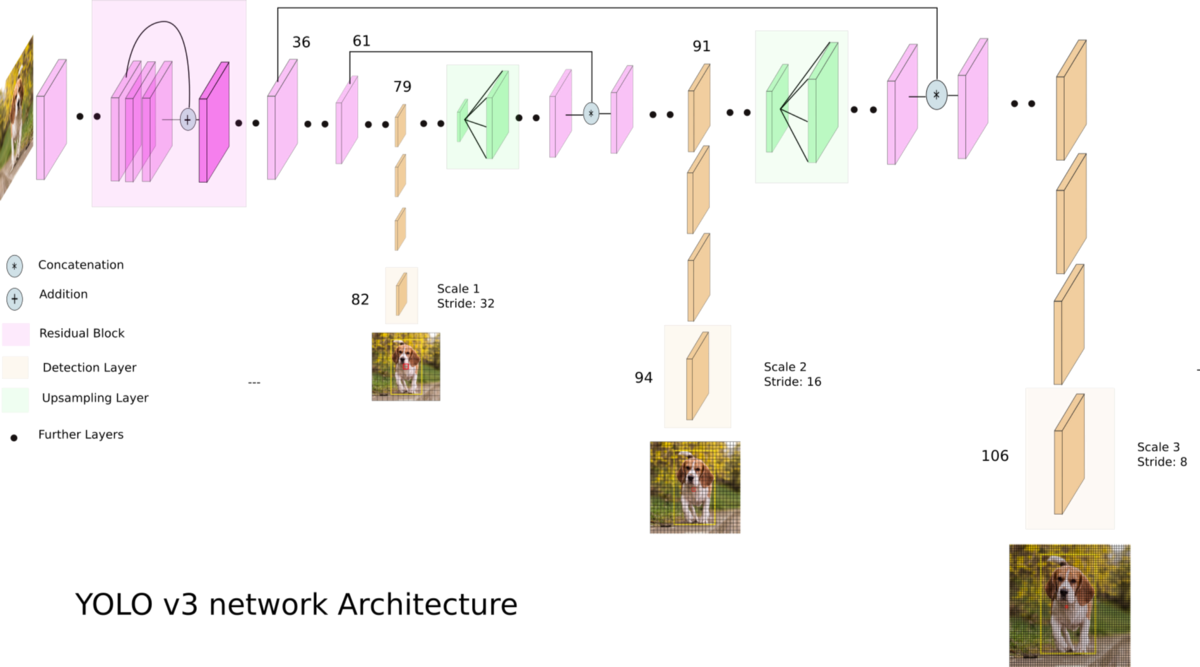

In [29]:
yolov3.save('yolov3.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


## Load Yolo Model

In [30]:
# load yolov3 model
model = load_model('yolov3.h5')

## Test YOLOv3 Model

person 99.65649247169495


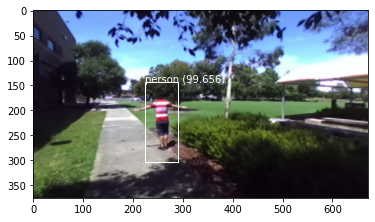

In [56]:
# based on https://github.com/experiencor/keras-yolo3
from numpy import expand_dims
from keras.models import load_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

# define the expected input shape for the model
input_w, input_h = 640, 386
# define our new photo
photo_filename = "Images/11_OUTSIDE_7393.png"
# photo_filename = "zebra.jpg"

# load and prepare image
image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))

# make prediction
yhat = model.predict(image)

# define the anchors
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]

# define the probability threshold for detected objects
class_threshold = 0.3
boxes = list()
for i in range(len(yhat)):
	# decode the output of the network
	boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)

# correct the sizes of the bounding boxes for the shape of the image
correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)

# suppress non-maximal boxes
do_nms(boxes, 0.4)

# define the labels
labels = ["person"]

# get the details of the detected objects.
v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)

# summarize what we found
for i in range(len(v_boxes)):
	print(v_labels[i], v_scores[i])
 
# draw what we found
draw_boxes(photo_filename, v_boxes, v_labels, v_scores)

# Depth Perception

In [32]:
INIT_LR = 0.001
NUM_EPOCHS = 25
BATCH_SIZE = 32
INPUT_SIZE = (376, 672)
METRICS_CI = [
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc',curve='ROC',),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  INIT_LR,
  decay_steps=train_gen.__len__() * 1000,
  decay_rate=10,
  staircase=False)

# Hyperparameters.
parameters = {
    # Compile parameters.
    "optimizer": tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    "loss": tf.keras.losses.MeanSquaredError(),
    "metrics": METRICS_CI,

    # Generator Parameters.
    "batch_size": BATCH_SIZE,

    # Fit perameters.
    "epochs": NUM_EPOCHS
}

reg_lambda = 0.001

Found 9946 validated image filenames.
Found 1243 validated image filenames.
Found 1244 validated image filenames.


In [ ]:
import os

import torch


def save_weights(model, filename, path="./saved_models"):
    if not os.path.isdir(path):
        os.makedirs(path)

    fpath = os.path.join(path, filename)
    torch.save(model.state_dict(), fpath)
    return


def save_checkpoint(model, optimizer, epoch, filename, root="./checkpoints"):
    if not os.path.isdir(root):
        os.makedirs(root)

    fpath = os.path.join(root, filename)
    torch.save(
        {
            "model": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "epoch": epoch
        }
        , fpath)


def load_weights(model, filename, path="./saved_models"):
    fpath = os.path.join(path, filename)
    state_dict = torch.load(fpath)
    model.load_state_dict(state_dict)
    return model


def load_checkpoint(fpath, model, optimizer=None):
    ckpt = torch.load(fpath, map_location='cpu')
    if optimizer is None:
        optimizer = ckpt.get('optimizer', None)
    else:
        optimizer.load_state_dict(ckpt['optimizer'])
    epoch = ckpt['epoch']

    if 'model' in ckpt:
        ckpt = ckpt['model']
    load_dict = {}
    for k, v in ckpt.items():
        if k.startswith('module.'):
            k_ = k.replace('module.', '')
            load_dict[k_] = v
        else:
            load_dict[k] = v

    modified = {}  # backward compatibility to older naming of architecture blocks
    for k, v in load_dict.items():
        if k.startswith('adaptive_bins_layer.embedding_conv.'):
            k_ = k.replace('adaptive_bins_layer.embedding_conv.',
                           'adaptive_bins_layer.conv3x3.')
            modified[k_] = v
            # del load_dict[k]

        elif k.startswith('adaptive_bins_layer.patch_transformer.embedding_encoder'):

            k_ = k.replace('adaptive_bins_layer.patch_transformer.embedding_encoder',
                           'adaptive_bins_layer.patch_transformer.embedding_convPxP')
            modified[k_] = v
            # del load_dict[k]
        else:
            modified[k] = v  # else keep the original

    model.load_state_dict(modified)
    return model, optimizer, epoch

In [40]:
import glob
import numpy as np
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
import torch
import torch.nn as nn
import os

import base64
import math
import re
from io import BytesIO

import matplotlib.cm
import torch.nn
from PIL import Image
import matplotlib.pyplot as plt
from time import time
import torch.nn.functional as F

class RunningAverage:
    def __init__(self):
        self.avg = 0
        self.count = 0

    def append(self, value):
        self.avg = (value + self.count * self.avg) / (self.count + 1)
        self.count += 1

    def get_value(self):
        return self.avg


def denormalize(x, device='cpu'):
    mean = torch.Tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(device)
    std = torch.Tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(device)
    return x * std + mean


class RunningAverageDict:
    def __init__(self):
        self._dict = None

    def update(self, new_dict):
        if self._dict is None:
            self._dict = dict()
            for key, value in new_dict.items():
                self._dict[key] = RunningAverage()

        for key, value in new_dict.items():
            self._dict[key].append(value)

    def get_value(self):
        return {key: value.get_value() for key, value in self._dict.items()}


def colorize(value, vmin=10, vmax=1000, cmap='magma_r'):
    value = value.cpu().numpy()[0, :, :]
    invalid_mask = value == -1

    # normalize
    vmin = value.min() if vmin is None else vmin
    vmax = value.max() if vmax is None else vmax
    if vmin != vmax:
        value = (value - vmin) / (vmax - vmin)  # vmin..vmax
    else:
        # Avoid 0-division
        value = value * 0.
    # squeeze last dim if it exists
    # value = value.squeeze(axis=0)
    cmapper = matplotlib.cm.get_cmap(cmap)
    value = cmapper(value, bytes=True)  # (nxmx4)
    value[invalid_mask] = 255
    img = value[:, :, :3]

    #     return img.transpose((2, 0, 1))
    return img


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def compute_errors(gt, pred):
    thresh = np.maximum((gt / pred), (pred / gt))
    a1 = (thresh < 1.25).mean()
    a2 = (thresh < 1.25 ** 2).mean()
    a3 = (thresh < 1.25 ** 3).mean()

    abs_rel = np.mean(np.abs(gt - pred) / gt)
    sq_rel = np.mean(((gt - pred) ** 2) / gt)

    rmse = (gt - pred) ** 2
    rmse = np.sqrt(rmse.mean())

    rmse_log = (np.log(gt) - np.log(pred)) ** 2
    rmse_log = np.sqrt(rmse_log.mean())

    err = np.log(pred) - np.log(gt)
    silog = np.sqrt(np.mean(err ** 2) - np.mean(err) ** 2) * 100

    log_10 = (np.abs(np.log10(gt) - np.log10(pred))).mean()
    return dict(a1=a1, a2=a2, a3=a3, abs_rel=abs_rel, rmse=rmse, log_10=log_10, rmse_log=rmse_log,
                silog=silog, sq_rel=sq_rel)

def save_weights(model, filename, path="./saved_models"):
    if not os.path.isdir(path):
        os.makedirs(path)

    fpath = os.path.join(path, filename)
    torch.save(model.state_dict(), fpath)
    return


def save_checkpoint(model, optimizer, epoch, filename, root="./checkpoints"):
    if not os.path.isdir(root):
        os.makedirs(root)

    fpath = os.path.join(root, filename)
    torch.save(
        {
            "model": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "epoch": epoch
        }
        , fpath)


def load_weights(model, filename, path="./saved_models"):
    fpath = os.path.join(path, filename)
    state_dict = torch.load(fpath)
    model.load_state_dict(state_dict)
    return model


def load_checkpoint(fpath, model, optimizer=None):
    ckpt = torch.load(fpath, map_location='cpu')
    if optimizer is None:
        optimizer = ckpt.get('optimizer', None)
    else:
        optimizer.load_state_dict(ckpt['optimizer'])
    epoch = ckpt['epoch']

    if 'model' in ckpt:
        ckpt = ckpt['model']
    load_dict = {}
    for k, v in ckpt.items():
        if k.startswith('module.'):
            k_ = k.replace('module.', '')
            load_dict[k_] = v
        else:
            load_dict[k] = v

    modified = {}  # backward compatibility to older naming of architecture blocks
    for k, v in load_dict.items():
        if k.startswith('adaptive_bins_layer.embedding_conv.'):
            k_ = k.replace('adaptive_bins_layer.embedding_conv.',
                           'adaptive_bins_layer.conv3x3.')
            modified[k_] = v
            # del load_dict[k]

        elif k.startswith('adaptive_bins_layer.patch_transformer.embedding_encoder'):

            k_ = k.replace('adaptive_bins_layer.patch_transformer.embedding_encoder',
                           'adaptive_bins_layer.patch_transformer.embedding_convPxP')
            modified[k_] = v
            # del load_dict[k]
        else:
            modified[k] = v  # else keep the original

    model.load_state_dict(modified)
    return model, optimizer, epoch

class PatchTransformerEncoder(nn.Module):
    def __init__(self, in_channels, patch_size=10, embedding_dim=128, num_heads=4):
        super(PatchTransformerEncoder, self).__init__()
        encoder_layers = nn.TransformerEncoderLayer(embedding_dim, num_heads, dim_feedforward=1024)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=4)  # takes shape S,N,E

        self.embedding_convPxP = nn.Conv2d(in_channels, embedding_dim,
                                           kernel_size=patch_size, stride=patch_size, padding=0)

        self.positional_encodings = nn.Parameter(torch.rand(500, embedding_dim), requires_grad=True)

    def forward(self, x):
        embeddings = self.embedding_convPxP(x).flatten(2)  # .shape = n,c,s = n, embedding_dim, s
        # embeddings = nn.functional.pad(embeddings, (1,0))  # extra special token at start ?
        embeddings = embeddings + self.positional_encodings[:embeddings.shape[2], :].T.unsqueeze(0)

        # change to S,N,E format required by transformer
        embeddings = embeddings.permute(2, 0, 1)
        x = self.transformer_encoder(embeddings)  # .shape = S, N, E
        return x


class PixelWiseDotProduct(nn.Module):
    def __init__(self):
        super(PixelWiseDotProduct, self).__init__()

    def forward(self, x, K):
        n, c, h, w = x.size()
        _, cout, ck = K.size()
        assert c == ck, "Number of channels in x and Embedding dimension (at dim 2) of K matrix must match"
        y = torch.matmul(x.view(n, c, h * w).permute(0, 2, 1), K.permute(0, 2, 1))  # .shape = n, hw, cout
        return y.permute(0, 2, 1).view(n, cout, h, w)

class mViT(nn.Module):
    def __init__(self, in_channels, n_query_channels=128, patch_size=16, dim_out=256,
                 embedding_dim=128, num_heads=4, norm='linear'):
        super(mViT, self).__init__()
        self.norm = norm
        self.n_query_channels = n_query_channels
        self.patch_transformer = PatchTransformerEncoder(in_channels, patch_size, embedding_dim, num_heads)
        self.dot_product_layer = PixelWiseDotProduct()

        self.conv3x3 = nn.Conv2d(in_channels, embedding_dim, kernel_size=3, stride=1, padding=1)
        self.regressor = nn.Sequential(nn.Linear(embedding_dim, 256),
                                       nn.LeakyReLU(),
                                       nn.Linear(256, 256),
                                       nn.LeakyReLU(),
                                       nn.Linear(256, dim_out))

    def forward(self, x):
        # n, c, h, w = x.size()
        tgt = self.patch_transformer(x.clone())  # .shape = S, N, E

        x = self.conv3x3(x)

        regression_head, queries = tgt[0, ...], tgt[1:self.n_query_channels + 1, ...]

        # Change from S, N, E to N, S, E
        queries = queries.permute(1, 0, 2)
        range_attention_maps = self.dot_product_layer(x, queries)  # .shape = n, n_query_channels, h, w

        y = self.regressor(regression_head)  # .shape = N, dim_out
        if self.norm == 'linear':
            y = torch.relu(y)
            eps = 0.1
            y = y + eps
        elif self.norm == 'softmax':
            return torch.softmax(y, dim=1), range_attention_maps
        else:
            y = torch.sigmoid(y)
        y = y / y.sum(dim=1, keepdim=True)
        return y, range_attention_maps

class UpSampleBN(nn.Module):
    def __init__(self, skip_input, output_features):
        super(UpSampleBN, self).__init__()

        self._net = nn.Sequential(nn.Conv2d(skip_input, output_features, kernel_size=3, stride=1, padding=1),
                                  nn.BatchNorm2d(output_features),
                                  nn.LeakyReLU(),
                                  nn.Conv2d(output_features, output_features, kernel_size=3, stride=1, padding=1),
                                  nn.BatchNorm2d(output_features),
                                  nn.LeakyReLU())

    def forward(self, x, concat_with):
        up_x = F.interpolate(x, size=[concat_with.size(2), concat_with.size(3)], mode='bilinear', align_corners=True)
        f = torch.cat([up_x, concat_with], dim=1)
        return self._net(f)


class DecoderBN(nn.Module):
    def __init__(self, num_features=2048, num_classes=1, bottleneck_features=2048):
        super(DecoderBN, self).__init__()
        features = int(num_features)

        self.conv2 = nn.Conv2d(bottleneck_features, features, kernel_size=1, stride=1, padding=1)

        self.up1 = UpSampleBN(skip_input=features // 1 + 112 + 64, output_features=features // 2)
        self.up2 = UpSampleBN(skip_input=features // 2 + 40 + 24, output_features=features // 4)
        self.up3 = UpSampleBN(skip_input=features // 4 + 24 + 16, output_features=features // 8)
        self.up4 = UpSampleBN(skip_input=features // 8 + 16 + 8, output_features=features // 16)

        #         self.up5 = UpSample(skip_input=features // 16 + 3, output_features=features//16)
        self.conv3 = nn.Conv2d(features // 16, num_classes, kernel_size=3, stride=1, padding=1)
        # self.act_out = nn.Softmax(dim=1) if output_activation == 'softmax' else nn.Identity()

    def forward(self, features):
        x_block0, x_block1, x_block2, x_block3, x_block4 = features[4], features[5], features[6], features[8], features[
            11]

        x_d0 = self.conv2(x_block4)

        x_d1 = self.up1(x_d0, x_block3)
        x_d2 = self.up2(x_d1, x_block2)
        x_d3 = self.up3(x_d2, x_block1)
        x_d4 = self.up4(x_d3, x_block0)
        #         x_d5 = self.up5(x_d4, features[0])
        out = self.conv3(x_d4)
        # out = self.act_out(out)
        # if with_features:
        #     return out, features[-1]
        # elif with_intermediate:
        #     return out, [x_block0, x_block1, x_block2, x_block3, x_block4, x_d1, x_d2, x_d3, x_d4]
        return out


class Encoder(nn.Module):
    def __init__(self, backend):
        super(Encoder, self).__init__()
        self.original_model = backend

    def forward(self, x):
        features = [x]
        for k, v in self.original_model._modules.items():
            if (k == 'blocks'):
                for ki, vi in v._modules.items():
                    features.append(vi(features[-1]))
            else:
                features.append(v(features[-1]))
        return features


class UnetAdaptiveBins(nn.Module):
    def __init__(self, backend, n_bins=100, min_val=0.1, max_val=10, norm='linear'):
        super(UnetAdaptiveBins, self).__init__()
        self.num_classes = n_bins
        self.min_val = min_val
        self.max_val = max_val
        self.encoder = Encoder(backend)
        self.adaptive_bins_layer = mViT(128, n_query_channels=128, patch_size=16,
                                        dim_out=n_bins,
                                        embedding_dim=128, norm=norm)

        self.decoder = DecoderBN(num_classes=128)
        self.conv_out = nn.Sequential(nn.Conv2d(128, n_bins, kernel_size=1, stride=1, padding=0),
                                      nn.Softmax(dim=1))

    def forward(self, x, **kwargs):
        unet_out = self.decoder(self.encoder(x), **kwargs)
        bin_widths_normed, range_attention_maps = self.adaptive_bins_layer(unet_out)
        out = self.conv_out(range_attention_maps)

        # Post process
        # n, c, h, w = out.shape
        # hist = torch.sum(out.view(n, c, h * w), dim=2) / (h * w)  # not used for training

        bin_widths = (self.max_val - self.min_val) * bin_widths_normed  # .shape = N, dim_out
        bin_widths = nn.functional.pad(bin_widths, (1, 0), mode='constant', value=self.min_val)
        bin_edges = torch.cumsum(bin_widths, dim=1)

        centers = 0.5 * (bin_edges[:, :-1] + bin_edges[:, 1:])
        n, dout = centers.size()
        centers = centers.view(n, dout, 1, 1)

        pred = torch.sum(out * centers, dim=1, keepdim=True)

        return bin_edges, pred

    def get_1x_lr_params(self):  # lr/10 learning rate
        return self.encoder.parameters()

    def get_10x_lr_params(self):  # lr learning rate
        modules = [self.decoder, self.adaptive_bins_layer, self.conv_out]
        for m in modules:
            yield from m.parameters()

    @classmethod
    def build(cls, n_bins, **kwargs):
        basemodel_name = 'tf_efficientnet_b5_ap'

        print('Loading base model ()...'.format(basemodel_name), end='')
        basemodel = torch.hub.load('rwightman/gen-efficientnet-pytorch', basemodel_name, pretrained=True)
        print('Done.')

        # Remove last layer
        print('Removing last two layers (global_pool & classifier).')
        basemodel.global_pool = nn.Identity()
        basemodel.classifier = nn.Identity()

        # Building Encoder-Decoder model
        print('Building Encoder-Decoder model..', end='')
        m = cls(basemodel, n_bins=n_bins, **kwargs)
        print('Done.')
        return m


def _is_pil_image(img):
    return isinstance(img, Image.Image)


def _is_numpy_image(img):
    return isinstance(img, np.ndarray) and (img.ndim in {2, 3})


class ToTensor(object):
    def __init__(self):
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    def __call__(self, image, target_size=(640, 480)):
        # image = image.resize(target_size)
        image = self.to_tensor(image)
        image = self.normalize(image)
        return image

    def to_tensor(self, pic):
        if not (_is_pil_image(pic) or _is_numpy_image(pic)):
            raise TypeError(
                'pic should be PIL Image or ndarray. Got {}'.format(type(pic)))

        if isinstance(pic, np.ndarray):
            img = torch.from_numpy(pic.transpose((2, 0, 1)))
            return img

        # handle PIL Image
        if pic.mode == 'I':
            img = torch.from_numpy(np.array(pic, np.int32, copy=False))
        elif pic.mode == 'I;16':
            img = torch.from_numpy(np.array(pic, np.int16, copy=False))
        else:
            img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))
        # PIL image mode: 1, L, P, I, F, RGB, YCbCr, RGBA, CMYK
        if pic.mode == 'YCbCr':
            nchannel = 3
        elif pic.mode == 'I;16':
            nchannel = 1
        else:
            nchannel = len(pic.mode)
        img = img.view(pic.size[1], pic.size[0], nchannel)

        img = img.transpose(0, 1).transpose(0, 2).contiguous()
        if isinstance(img, torch.ByteTensor):
            return img.float()
        else:
            return img

In [48]:
class InferenceHelper:
    def __init__(self, dataset='nyu', device='cuda:0'):
        self.toTensor = ToTensor()
        self.device = device
        if dataset == 'nyu':
            self.min_depth = 1e-3
            self.max_depth = 10
            self.saving_factor = 1000  # used to save in 16 bit
            model = UnetAdaptiveBins.build(n_bins=256, min_val=self.min_depth, max_val=self.max_depth)
            pretrained_path = "/content/drive/MyDrive/DL/AdaBins_nyu.pt"
        elif dataset == 'kitti':
            self.min_depth = 1e-3
            self.max_depth = 80
            self.saving_factor = 256
            model = UnetAdaptiveBins.build(n_bins=256, min_val=self.min_depth, max_val=self.max_depth)
            pretrained_path = "/content/drive/MyDrive/DL/AdaBins_kitti.pt"
        else:
            raise ValueError("dataset can be either 'nyu' or 'kitti' but got {}".format(dataset))

        model, _, _ = load_checkpoint(pretrained_path, model)
        model.eval()
        self.model = model.to(self.device)

    @torch.no_grad()
    def predict_pil(self, pil_image, visualized=False):
        # pil_image = pil_image.resize((640, 480))
        img = np.asarray(pil_image) / 255.

        img = self.toTensor(img).unsqueeze(0).float().to(self.device)
        bin_centers, pred = self.predict(img)

        if visualized:
            viz = colorize(torch.from_numpy(pred).unsqueeze(0), vmin=None, vmax=None, cmap='magma')
            # pred = np.asarray(pred*1000, dtype='uint16')
            viz = Image.fromarray(viz)
            return bin_centers, pred, viz
        return bin_centers, pred

    @torch.no_grad()
    def predict(self, image):
        bins, pred = self.model(image)
        pred = np.clip(pred.cpu().numpy(), self.min_depth, self.max_depth)

        # Flip
        image = torch.Tensor(np.array(image.cpu().numpy())[..., ::-1].copy()).to(self.device)
        pred_lr = self.model(image)[-1]
        pred_lr = np.clip(pred_lr.cpu().numpy()[..., ::-1], self.min_depth, self.max_depth)

        # Take average of original and mirror
        final = 0.5 * (pred + pred_lr)
        final = nn.functional.interpolate(torch.Tensor(final), image.shape[-2:],
                                          mode='bilinear', align_corners=True).cpu().numpy()

        final[final < self.min_depth] = self.min_depth
        final[final > self.max_depth] = self.max_depth
        final[np.isinf(final)] = self.max_depth
        final[np.isnan(final)] = self.min_depth

        centers = 0.5 * (bins[:, 1:] + bins[:, :-1])
        centers = centers.cpu().squeeze().numpy()
        centers = centers[centers > self.min_depth]
        centers = centers[centers < self.max_depth]

        return centers, final

    @torch.no_grad()
    def predict_dir(self, test_dir, out_dir):
        os.makedirs(out_dir, exist_ok=True)
        transform = ToTensor()
        all_files = glob.glob(os.path.join(test_dir, "*"))
        self.model.eval()
        for f in tqdm(all_files):
            image = np.asarray(Image.open(f), dtype='float32') / 255.
            image = transform(image).unsqueeze(0).to(self.device)

            centers, final = self.predict(image)
            # final = final.squeeze().cpu().numpy()

            final = (final * self.saving_factor).astype('uint16')
            basename = os.path.basename(f).split('.')[0]
            save_path = os.path.join(out_dir, basename + ".png")

            Image.fromarray(final).save(save_path)

## Test

In [50]:
inside_inferHelper = InferenceHelper(dataset='nyu')
outside_inferHelper = InferenceHelper(dataset='kitti')

Loading base model ()...

Using cache found in /root/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master


Done.
Removing last two layers (global_pool & classifier).
Building Encoder-Decoder model..Done.
Loading base model ()...

Using cache found in /root/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master


Done.
Removing last two layers (global_pool & classifier).
Building Encoder-Decoder model..Done.


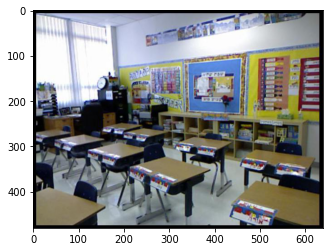

took :0.13958072662353516s


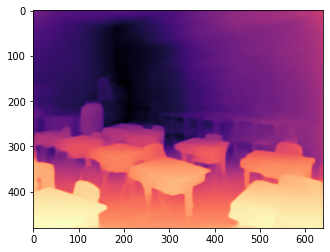

In [53]:
img = Image.open("classroom__rgb_00283.jpg")
plt.imshow(img)
plt.show()

start = time()
centers, pred = inside_inferHelper.predict_pil(img)
print(f"took :{time() - start}s")
plt.imshow(pred.squeeze(), cmap='magma_r')
plt.show()

Inside

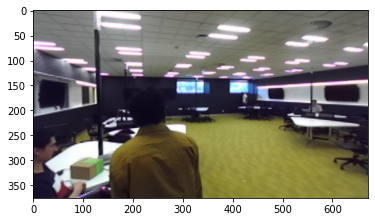

took :0.1337885856628418s


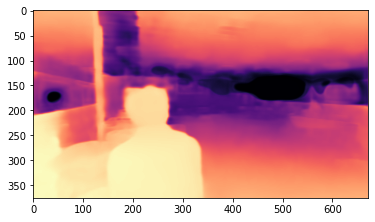

In [64]:
image = load_img("Images/01_INSIDE_00044.png")
plt.imshow(image)
plt.show()

start = time()
centers, pred = inside_inferHelper.predict_pil(image)
print(f"took :{time() - start}s")
plt.imshow(pred.squeeze(), cmap='magma_r')
plt.show()

Outside

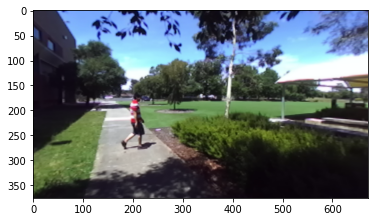

took :0.12733769416809082s


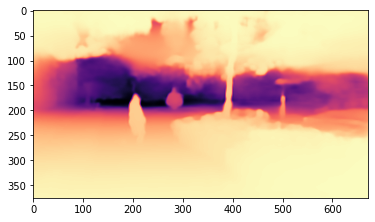

In [65]:
image = load_img("Images/11_OUTSIDE_7208.png")
plt.imshow(image)
plt.show()

start = time()
centers, pred = outside_inferHelper.predict_pil(image)
print(f"took :{time() - start}s")
plt.imshow(pred.squeeze(), cmap='magma_r')
plt.show()

## Transform Image Dataset into depth heatmap dataset
This is to speed up the training of the depth estimation

In [ ]:
from infer import InferenceHelper

infer_helper = InferenceHelper(dataset='nyu')

# predict depth of a batched rgb tensor
example_rgb_batch = ...  
bin_centers, predicted_depth = infer_helper.predict(example_rgb_batch)

# predict depth of a single pillow image
img = Image.open("test_imgs/classroom__rgb_00283.jpg")  # any rgb pillow image
bin_centers, predicted_depth = infer_helper.predict_pil(img)

# predict depths of images stored in a directory and store the predictions in 16-bit format in a given separate dir
infer_helper.predict_dir("/path/to/input/dir/containing_only_images/", "path/to/output/dir/")

# Depth Estimation
Depth estimation gives a numerical value based on the crop created from the depth heatmap model and bounding box from YOLOv3 Model.

## Data Generator

In [ ]:
from scipy.interpolate import interp1d
from PIL import Image
import random

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data_frame, batch_size=8, n_classes=2, data_mean=0, data_std=1, directory='', shuffle=True, augmentations=dict(), seed=30):
        'Initialization'

        self.n_classes = n_classes  # Number of classes. This is for a classification task

        # Generates a reproducable series of numbers from generation that are then given as a seed to the numpy shuffler.
        self.random =  random.seed(seed);

        self.shuffle = shuffle  # Flag to shuffle data at the end of epoch

        # The data is input as a pandas dataframe, we need to read the relevent fields
        self.data_frame = data_frame

        # Initialise the image labels into a list from the data frame.
        self.image_labels = data_frame['distance'].values.tolist() 

        self.batch_ids = np.arange(len(self.image_label)).tolist()

        # Used as the file path to the folder containing the images.
        self.directory = directory
        
        # Data normalization parameters
        self.data_mean = data_mean
        self.data_std = data_std
              
        # self.batch_ids = self.data_frame['file_path'].unique()

        # Set the augmentation set to calculate all augmentation permutations and apply them to to the batch of data effectively multiplying the amount of data.
        self.augmentations = augmentations
        
        # Shuffle the data before the start of the epoch.
        self.on_epoch_end()

    def __chunks__(self, lst, n):
      """Yield successive n-sized chunks from lst."""
      for i in range(0, len(lst), n):
          yield lst[i:i + n]

    def __len__(self):
        'Denotes the number of batches per epoch'
        return len(self.batch_ids)

    def __getitem__(self, index):
        'Generate one batch of data for the given index'

        # Generate indexes of the batch
        ids = self.shuffled_batch_ids[index]

        # Generate data
        X, y = self.__data_generation(ids)
        
        return X, y

    def on_epoch_end(self):
        'Updates batch ordering after each epoch'
        self.shuffled_batch_ids = self.batch_ids
        if self.shuffle == True:

          # Create random seed from the random generator that is seeded.
          np.random.seed(self.random)
          
          # Shuffle the group ordering
          np.random.shuffle(self.shuffled_batch_ids)

          # Shuffle each group
          for group in self.shuffled_batch_ids:
            np.random.shuffle(group)
  
  
    def __get_output(self, label, num_classes):
        return tf.keras.utils.to_categorical(label, num_classes=num_classes)

    # Support function
    def __data_generation(self, batch_indices):
        'Generates data containing batch_size samples' 
        
        # Get resolution for the batch of ids (they all have same resolution).
        resolution_dim = self.data_frame.iloc[batch_indices[0]]["resolution_dim"]
        
        # Initialization
        X = np.empty((len(batch_indices), *resolution_dim))
        action_labels = list()
        action_class_labels = list()

        # Generate data
        for i, row_index in enumerate(batch_indices):
            y1_label = self.image_labels[row_index][0]
            y2_label = self.image_labels[row_index][1]

            y1_hot = keras.utils.to_categorical(y1_label, num_classes=21)
            y2_hot = keras.utils.to_categorical(y2_label, num_classes=5)

            action_labels.append(y1_hot)
            action_class_labels.append(y2_hot)

            X[i,] = self.__read_data_instance(row_index, resolution_dim)

        action_labels = np.array(action_labels)
        action_class_labels = np.array(action_class_labels)

        return X, tuple([action_labels, action_class_labels])

    def __read_data_instance(self, row_index, dims):
      'Gets the image data from the row index, and can augment the pixels values if True, and apply normalisation'

      # Get the file name of the image at row index
      row = self.data_frame.iloc[row_index]

      filepath = self.directory + row['FileName']
      img = Image.open(filepath)
      img = np.asarray(img)

      # Augment the data if there are augmentation methods given.
      if len(self.augmentations) > 0:
          for aug in self.augmentations:
            if np.random.rand(1) < 0.5:
              img = aug(img)
      
      img = np.array(img)

      # Input normalization, making pixel values between 0..1
      img = img - self.data_mean
      img = img / self.data_std

      return img

In [ ]:
# Create the list of augmentation functions for data loader.
train_augmentations = [
    __aug_rotate,       
    __aug_brighten,     
    __aug_hue,
    __aug_saturation,
    __aug_flip,     
    __aug_quality, 
    __aug_contrast, 
    __shift_aug
]

data_mean = 0.
data_std = 255.0
directory='./Images/'


train_generator = DataGenerator(train_set_60_40, data_mean=data_mean, data_std=data_std, augmentations=train_augmentations, directory=directory)
val_generator = DataGenerator(validation_set_60_40, data_mean=data_mean, data_std=data_std, directory=directory)

NameError: ignored

In [ ]:
train_generator, val_generator, test_generator = get_imagery_data_sets(train_set, validation_set, test_set, "", "file_path", ["xmin", "xmax", "ymin", "ymax"], BATCH_SIZE, INPUT_SIZE)
model_name = "test"
history, model = run_model(model, parameters, model_name, train_generator, val_generator)

Found 9946 validated image filenames.
Found 1243 validated image filenames.
Found 1244 validated image filenames.
~~~~~~~~~~ test ~~~~~~~~~~
/bin/bash: /: Is a directory
Creating new model..


ValueError: ignored